<a href="https://colab.research.google.com/github/ShriPrathaa/LLM-Text-Detection/blob/main/Agnya_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jatayu04","key":"2ed66fe5714d1131bccacefb13320deb"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c llm-detect-ai-generated-text

 72% 1.00M/1.38M [00:00<00:00, 1.99MB/s]
100% 1.38M/1.38M [00:00<00:00, 2.57MB/s]


In [ ]:
! unzip /content/llm-detect-ai-generated-text.zip

Archive:  /content/llm-detect-ai-generated-text.zip
  inflating: sample_submission.csv   
  inflating: test_essays.csv         
  inflating: train_essays.csv        
  inflating: train_prompts.csv       


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


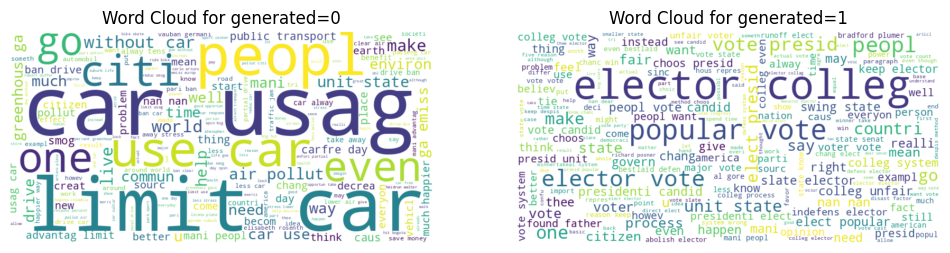

In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download NLTK stopwords
import nltk
nltk.download('stopwords')

# Load CSV file into a DataFrame
file_path = '/content/train_essays.csv'
df = pd.read_csv(file_path)

# Function to clean and preprocess text
def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation (except apostrophes)
    text = re.sub(r"[^\w\s']", '', text)

    return text

# Apply preprocessing to column 'text'
df['processed_text'] = df['text'].apply(preprocess_text)

# Separate based on 'generated' value
df['processed_text_0'] = df[df['prompt_id'] == 0]['processed_text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))
df['processed_text_1'] = df[df['prompt_id'] == 1]['processed_text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))

# Stemming
stemmer = PorterStemmer()
df['processed_text_0'] = df['processed_text_0'].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))
df['processed_text_1'] = df['processed_text_1'].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))

# Generate WordCloud for generated=0
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df['generated'] == 0]['processed_text_0']))

# Generate WordCloud for generated=1
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df['generated'] == 0]['processed_text_1']))

# Plot the WordClouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Word Cloud for generated=0')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Word Cloud for generated=1')
plt.axis('off')

plt.show()


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Assuming df['processed_text'] contains text data
df['sentences'] = df['text'].apply(sent_tokenize)

df['sentence_lengths'] = df['sentences'].apply(len)

In [ ]:
print(df[(df['generated'] == 1) & df['processed_text_0'].notna()]['processed_text_0'])


704                                                   nan
740                                                   nan
1262    limit car use caus pollut increas cost user re...
Name: processed_text_0, dtype: object


In [ ]:
print(df[(df['generated'] == 1) & df['processed_text_1'].notna()]['processed_text_1'])

704     essay analyz discuss prove one reason favor ke...
740     strongli believ elector colleg remain way bett...
1262                                                  nan
Name: processed_text_1, dtype: object


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold

# Assuming you have a DataFrame named df with 'processed_text_0', 'processed_text_1', and 'generated' columns

# Concatenate the processed text columns based on the 'generated' column
df['processed_text'] = df.apply(lambda row: row['processed_text_0'] if row['prompt_id'] == 0 else row['processed_text_1'], axis=1)

# Extract features and labels
X = df['processed_text']
y = df['generated']

# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the text data into a matrix of token counts
X_count = count_vectorizer.fit_transform(X)

# Initialize TfidfTransformer
tfidf_transformer = TfidfTransformer()

# Normalize the token counts using TfidfTransformer
X_tfidf = tfidf_transformer.fit_transform(X_count)

# Initialize StratifiedKFold with 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# Drop the specified columns
df.drop(['processed_text_0', 'processed_text_1', 'sentences'], axis=1, inplace=True)

In [ ]:
import openai

# Set your OpenAI GPT-3 API key
openai.api_key = 'YOUR_API_KEY'

# Replace 'YOUR_SENTENCE' with the sentence you want to analyze
original_sentence = 'YOUR_SENTENCE'

# Number of perturbations
num_perturbations = 5

# Create perturbations by slightly modifying the original sentence
perturbations = [f"{original_sentence} [perturbation {i+1}]" for i in range(num_perturbations)]

# Initialize a list to store log probabilities
log_probabilities = []

# Iterate through perturbations and get log probabilities
for perturbation in perturbations:
    response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=perturbation,
        max_tokens=100,
    )

    log_probability = response['choices'][0]['logprobs']['token_logprobs'][0]

    log_probabilities.append(log_probability)

# Display original sentence log probability
original_response = openai.Completion.create(
    engine="text-davinci-002",
    prompt=original_sentence,
    max_tokens=100,
)
original_log_probability = original_response['choices'][0]['logprobs']['token_logprobs'][0]

print(f"Original Sentence: {original_sentence}")
print(f"Original Log Probability: {original_log_probability}\n")

# Display perturbations and their log probabilities
for i, (perturbation, log_prob) in enumerate(zip(perturbations, log_probabilities), 1):
    print(f"Perturbation {i}: {perturbation}")
    print(f"Log Probability: {log_prob}\n")
